In [1]:
#jk

import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm_notebook

import logging as lg

from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score,precision_score, recall_score,  confusion_matrix, roc_curve, roc_auc_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set(rc={'figure.figsize':(20,7)})



class LogisticRegActivityRecognition:
    
    def __init__(self, dir_path):
        self.dir_path = dir_path
        
    def create_logger(self):
        try:
            lg.basicConfig(filename='activity_recogition_logistic_logger.log', level = lg.INFO ,format='%(asctime)s - %(levelname)s - %(message)s')
        except Exception as e:
            print(e)
        
    def create_sub_dir_list(self):
        try:
            for root, dirs, files in os.walk(self.dir_path):
                subdir_path_list = [os.path.join(root, name) for name in dirs]
                lg.info('creating sub directory list')
                return subdir_path_list
        except Exception as e:
            lg.exception(str(e))
        
    def load_data(self, subdir_path_list):
        try:
            main_df = []

            for subdir_path in tqdm_notebook(subdir_path_list):
                dir_name = subdir_path.split('\\')[-1]
                sub_df = []

                for file in glob.glob(os.path.join(subdir_path, '*')):
                    tmp_df = pd.read_csv(file, skiprows=4, error_bad_lines=False)
                    sub_df.append(tmp_df)

                tmp_df_concat = pd.concat(sub_df)
                tmp_df_concat['label'] = dir_name
                lg.info('{} - loading data....'.format(dir_name))

                # missing value imputation
                if tmp_df_concat.isnull().any().any():
                    for col in tmp_df_concat.columns:
                        if tmp_df_concat[col].isnull().values.any():
                            tmp_df_concat[col].fillna(tmp_df_concat[col].mean(), inplace=True)
                main_df.append(tmp_df_concat)
                
            combined_df = pd.concat(main_df)
            combined_df.reset_index(inplace=True, drop=True)
            lg.info('Combined  data')
            return combined_df
        
        except Exception as e:
            lg.exception(str(e))
        
    
    def drop_column(self, df, column_name):
        df.drop(column_name, axis=1, inplace=True)
        lg.info('dropped {} column'.format(column_name))
        return df
    
    def create_profile_report(self, df, file_name):
        try:
            profile_report_obj = ProfileReport(df)
            profile_report_obj.to_file(file_name)
        except Exception as e:
            lg.exception(str(e))
        else:
            lg.info('profile report created successfully for {} !!!'.format(file_name))
            
    def remove_ouliers_percentile(self, df):
        try:
            df_new = df.copy()

            q = df_new['avg_rss12'].quantile(.02)
            df_new = df_new[df_new['avg_rss12'] > q]

            q = df_new['var_rss12'].quantile(.97)
            df_new = df_new[df_new['var_rss12'] < q]

            q = df_new['avg_rss13'].quantile(.98)
            df_new = df_new[df_new['avg_rss13'] < q]

            q = df_new['var_rss13'].quantile(.98)
            df_new = df_new[df_new['var_rss13'] < q]

            q = df_new['avg_rss23'].quantile(.98)
            df_new = df_new[df_new['avg_rss23'] < q]

            q = df_new['var_rss23'].quantile(.99)
            df_new = df_new[df_new['var_rss23'] < q]
            df_new.reset_index(inplace=True, drop=True)
            
            lg.info('removed ouliers values using percentile method!!!')
            return df_new
        
        except Exception as e:
            lg.exception(str(e))
    
    def plot_correlation_heatmap(self, df):
        try:
            lg.info('plotting correlation heatmap!!!')
            sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)
        except Exception as e:
            lg.exception(str(e))
        
    def apply_OrdinalEncoder(self, df, column_name):
        try:
            ord_enc = OrdinalEncoder()
            df[column_name] = ord_enc.fit_transform(df[[column_name]])
            lg.info('applying OrdinalEncoder!!!')
            return df
        except Exception as e:
            lg.exception(str(e))
    
    def split_feature_target(self, df, target_column):
        try:
            X = df.drop(columns=[target_column])
            y = df[target_column]
            lg.info('splitting feature and target!')
            return X, y
        except Exception as e:
            lg.exception(str(e))
        
    def scaling_standard_scaler(self, feature):
        try:
            scalar = StandardScaler()
            X_scaled = scalar.fit_transform(feature)
            X_scaled_df = pd.DataFrame(X_scaled, columns= feature.columns)
            lg.info('Applying standard scaler!!!')
            return X_scaled, X_scaled_df
        except Exception as e:
            lg.exception(str(e))
            
    
    def find_multicollinearity_vif_score(self, features, features_scaled):
        try:
            vif_df = pd.DataFrame([[features.columns[i], variance_inflation_factor(features_scaled,i)] for i in range(features_scaled.shape[1])], columns=["FEATURE", "VIF_SCORE"])
            lg.info('calculated VIF score!!!')
            if len(vif_df[vif_df['VIF_SCORE'] > 10]['FEATURE']) > 0:
                lg.info('columns which has VIF score > 10')
                lg.info(vif_df[vif_df['VIF_SCORE'] > 10]['FEATURE'])
            else:
                lg.info(' "NO" columns which has VIF score > 10')
        except Exception as e:
            lg.exception(str(e))
    
    def spliting_train_test(self, X, y):
        try:
            x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
            lg.info('spliting train test')
            return x_train, x_test, y_train, y_test
        except Exception as e:
            lg.exception(str(e))
            
    def find_mean_test_score_gridSearch(self, x_train, y_train):
        try:
            solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
            parameters = dict(solver=solver_list)
            lr = LogisticRegression(random_state=7, multi_class="auto", n_jobs=-1, C=1)
            clf = GridSearchCV(lr, parameters, cv=5)
            clf.fit(x_train, y_train)
            scores = clf.cv_results_['mean_test_score']
            eval_df = pd.DataFrame(solver_list,columns=['solver'])
            eval_df['grid_search_train_score'] = scores
            lg.info('finding mean_test_score using gridSearch!!!')
            return eval_df
        except Excepton as e:
            lg.exception(str(e))
    
    def find_roc_accuracy_precision(self, x_train, x_test, y_train, y_test, eval_df):
        try:
            roc_list = []
            solvers = ['liblinear','newton-cg', 'sag', 'saga', 'lbfgs']

            for sol in solvers: 
                logreg = LogisticRegression(random_state=7, multi_class="auto", n_jobs=-1, C=1, solver=sol)
                logreg.fit(x_train, y_train)
                y_pred = logreg.predict(x_test)
                auc = roc_auc_score(y_test, logreg.predict_proba(x_test), multi_class='ovr')
                score_test_data = logreg.score(x_test, y_test)
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average='weighted')
                recall = recall_score(y_test, y_pred, average='weighted')
                roc_list.append([score_test_data, auc,accuracy,precision,recall])
            eval_df[['score_test_data','roc_auc_score', 'accuracy','precision','recall']] = roc_list
            lg.info('finding test score, rocauc score,accuracy,precision, recall...!!!')
            return eval_df
        except Exception as e:
            lg.exception(str(e))
    
    def create_and_save_model(self, file_name):
        try:
            final_model = LogisticRegression(random_state=7, multi_class="auto", n_jobs=-1, C=1, solver='saga')
            #save the model
            pickle.dump(final_model,open(file_name,'wb'))
            lg.info('create the model for and_save the model')
            return final_model
        except Exception as e:
            lg.exception(str(e))
           
    def prediction_plot_report_generation(self, x_train, x_test, y_train, y_test, model_file_name):
        try:
            model = pickle.load(open(model_file_name, 'rb'))
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            lg.info('prediction for X_test...')
            cm = confusion_matrix(y_test,y_pred)
            lg.info('creating confusion matrix...')
            print('*****************confusion matrix **************************************')
            print(cm)
            #visualizing confusion matrix
            plt.figure(figsize = (20,11))
            sns.heatmap(cm, annot=True, fmt="d")
            plt.xlabel('Predicted')
            plt.ylabel('Truth')
            lg.info('creating heatmap for confusion matrix...')
            #classification report
            #target wise precision  recall  f1-score
            print('*****************classification_report *********************************')
            print(classification_report(y_test,y_pred))
            lg.info('creating classification_report...')
        except Exception as e:
            lg.exception(str(e))


In [2]:
LogisticReg = LogisticRegActivityRecognition('R:/ML_New/FullStackDS/projects/ML/chl_activity_recognition_logistic_reg/data')
LogisticReg.create_logger()
subdir_path_list = LogisticReg.create_sub_dir_list()
combined_df = LogisticReg.load_data(subdir_path_list)
print('shape',combined_df.shape)

  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\jagan\AppData\Local\Temp/ipykernel_17460/807758131.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  combined_df = LogisticReg.load_data(subdir_path_list)
b'Skipping line 485: expected 7 fields, saw 8\n'
b'Skipping line 485: expected 7 fields, saw 8\n'


shape (42237, 8)


In [3]:
combined_df = LogisticReg.drop_column(combined_df, '# Columns: time')
LogisticReg.create_profile_report(combined_df, file_name='activity_recogition_logistic_regression.html')

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

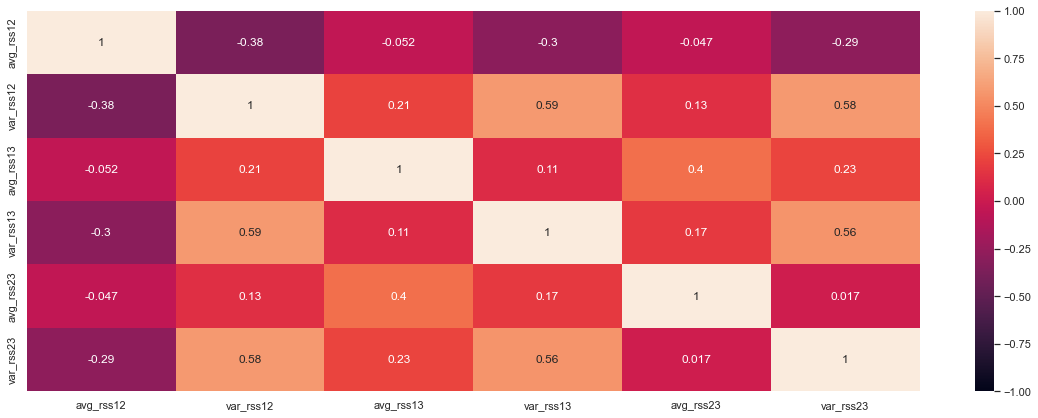

In [4]:
combined_df = LogisticReg.remove_ouliers_percentile(combined_df)
LogisticReg.plot_correlation_heatmap(combined_df)

In [5]:
combined_df = LogisticReg.apply_OrdinalEncoder(combined_df, column_name='label')
X, y = LogisticReg.split_feature_target(combined_df, target_column='label')

In [6]:
X_scaled, X_scaled_df = LogisticReg.scaling_standard_scaler(X)
LogisticReg.create_profile_report(X_scaled_df, file_name='activity_recogition_after_scaled.html')

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
vif_df = LogisticReg.find_multicollinearity_vif_score(X_scaled_df, X_scaled)
x_train, x_test, y_train, y_test = LogisticReg.spliting_train_test(X_scaled, y)

In [8]:
eval_df = LogisticReg.find_mean_test_score_gridSearch(x_train, y_train)

C:\Users\jagan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\Users\jagan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\Users\jagan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\Users\jagan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


In [9]:
eval_df = LogisticReg.find_roc_accuracy_precision(x_train, x_test, y_train, y_test, eval_df)
eval_df
#saga performs well compared with other solvers..so, creating final model using saga solver

C:\Users\jagan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


,solver,grid_search_train_score,score_test_data,roc_auc_score,accuracy,precision,recall
0,liblinear,0.634731,0.640259,0.921689,0.640259,0.630342,0.640259
1,newton-cg,0.654472,0.656562,0.929530,0.656562,0.654576,0.656562
2,lbfgs,0.654472,0.656427,0.929529,0.656427,0.654411,0.656427
3,sag,0.654472,0.656427,0.929530,0.656427,0.654451,0.656427
4,saga,0.654472,0.656696,0.929530,0.656696,0.654697,0.656696


In [10]:
final_model = LogisticReg.create_and_save_model(file_name = 'activity_recognition_logistic_reg.sav')

*****************confusion matrix **************************************
[[ 279    1   14    0   89    2    0]
 [  21  284   17   43   42    0    4]
 [   3    8  780    0   63   18  331]
 [   0   45    1 1256   30  121    4]
 [  57   78   43  198  705  303    4]
 [   1    0   30  131  414  896    3]
 [   1    7  404    0   18    1  672]]
*****************classification_report *********************************
              precision    recall  f1-score   support

         0.0       0.77      0.72      0.75       385
         1.0       0.67      0.69      0.68       411
         2.0       0.61      0.65      0.63      1203
         3.0       0.77      0.86      0.81      1457
         4.0       0.52      0.51      0.51      1388
         5.0       0.67      0.61      0.64      1475
         6.0       0.66      0.61      0.63      1103

    accuracy                           0.66      7422
   macro avg       0.67      0.66      0.66      7422
weighted avg       0.65      0.66      0.65  

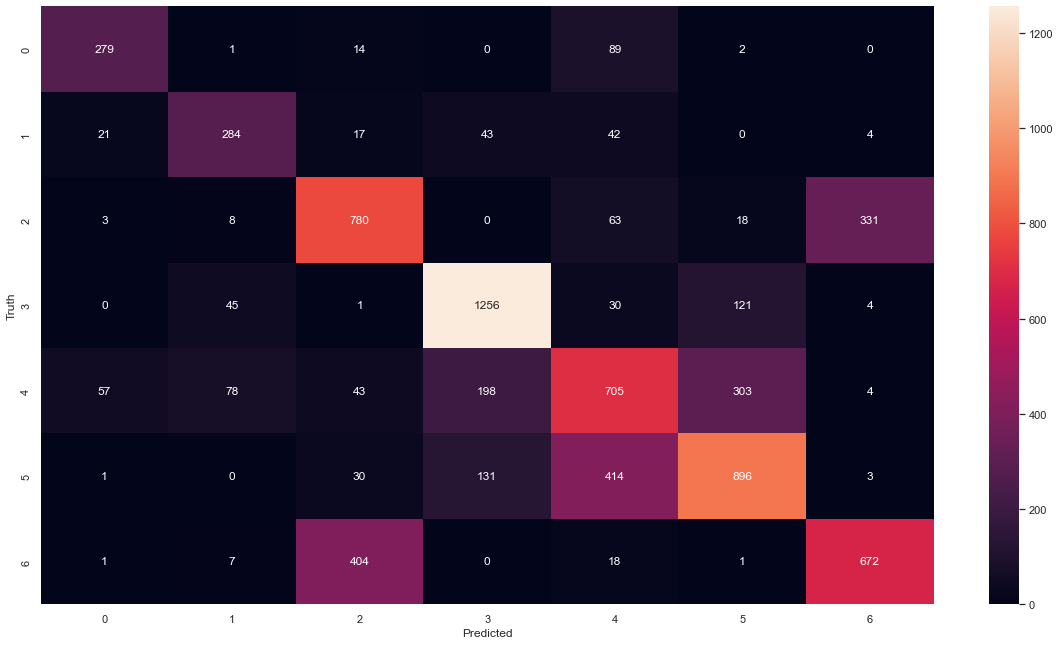

In [11]:
LogisticReg.prediction_plot_report_generation(x_train, x_test, y_train, y_test, model_file_name='activity_recognition_logistic_reg.sav')